In [34]:
import scipy
import csv as csv
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sk
from numpy import array
import cv2
import os
import matplotlib as mpl
import matplotlib.pylab as plt
import random
from PIL import Image 
from PIL import ImageFilter
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, neighbors, grid_search, cross_validation,metrics
import re

from subprocess import check_output

In [21]:

train_directory="./train/"
test_directory="./test1/"

def images(image_directory):
    return [image_directory + image  for image in os.listdir(image_directory)]
# 이미지 디렉토리에 있는 리스트 전부를 뿌려준다. 주소와 이미지 이름을 같이출력
images(train_directory)

# 테스트와 트레인 데이터 위치 지정 


def extract_labels(file_names):
    n=len(file_names)
    y=np.zeros(n,dtype=np.int32)
    
    for i,filename in enumerate(file_names):# 캣에 0을 할당 개에 1할당
        if 'cat'in str(filename):
            y[i]=0
        else:
            y[i]=1
            
    return y

def img_to_matrix(filename, verbose=False):# 이미지를 리사이즈하는 작업
        
    #이미지  파일명으로 파일을 불러와서 그걸 rgb픽셀 넘파이로 바꿔주는 작업
    img = Image.open(filename).convert("L")
    # img = Image.fromarray(filename)
    
    img = img.resize((64,64),Image.ANTIALIAS)
    #이미지 사이즈를 28,28 로 줄여준다.
    img=img.filter(ImageFilter.GaussianBlur(255))
    pix=img.histogram()
   
    return pix

# Function to flatten numpy array
def flatten_image(img):
    
    '''
    takes in an (m, n) numpy array and flattens it 
    into an array of shape (1, m * n)
    # 이미지를  1차원으로 펴는 작업'''
    
    img_wide = img.reshape(1, img.shape[0])
    return img_wide[0]








In [22]:
k=images(train_directory)

In [6]:
img_1=img_to_matrix(k[1])
type(img_1)

list

In [7]:
img_1=np.array(img_1)


In [40]:
img_1=flatten_image(img_1)

In [8]:
img_1.shape

(256,)

In [48]:

%%time
train_image_names=images(train_directory) #여기서 트레인y 라벨을 뽑아준다.

train_y=extract_labels(train_image_names)
np.save('train_y',train_y)

# 트레이닝 데이타를 준비하자
from PIL import Image
train_data=[]
for i in images(train_directory): #트레인데이터 파일 주소
    img=img_to_matrix(i)
    img=np.array(img)
    img=flatten_image(img)
    train_data.append(img)
    
    
print (len(train_data))




25000
Wall time: 3min 8s


In [49]:
train_x, test_x, y_train_, test_y = cross_validation.train_test_split(train_data, train_y, test_size=0.2, random_state=0)

In [50]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(train_x,y_train_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [51]:
y_predict_knn = knn.predict(train_x)
y_predict_knn

array([1, 1, 0, ..., 1, 1, 1])

In [27]:

## KNN: Accuracy
knn_accuracy = np.where(y_predict_knn == y_train_, 1, 0).sum()/float(len(y_train_))
knn_accuracy

0.66764999999999997

In [52]:
from sklearn.metrics import classification_report
print (classification_report(y_train_,y_predict_knn))

             precision    recall  f1-score   support

          0       0.67      0.66      0.66     10004
          1       0.66      0.68      0.67      9996

avg / total       0.67      0.67      0.67     20000



In [66]:
training_accuray=knn.score(train_x,y_train_)

In [67]:
training_accuray

0.62909999999999999

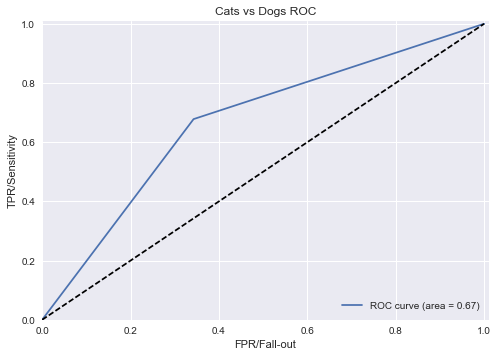

In [136]:
fpr, tpr, thresholds = metrics.roc_curve(y_train_,y_predict_knn)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Cats vs Dogs ROC")
plt.legend(loc = 'lower right')
plt.savefig ('train.jpg', dpi=300, transparent=False)
plt.show()

In [53]:
knn_test_y=knn.predict(test_x)
print (classification_report(test_y,knn_test_y))

             precision    recall  f1-score   support

          0       0.50      0.49      0.50      2496
          1       0.50      0.51      0.50      2504

avg / total       0.50      0.50      0.50      5000



In [68]:
test_accuracy=knn.score(test_x,test_y)

In [69]:
test_accuracy

0.49859999999999999

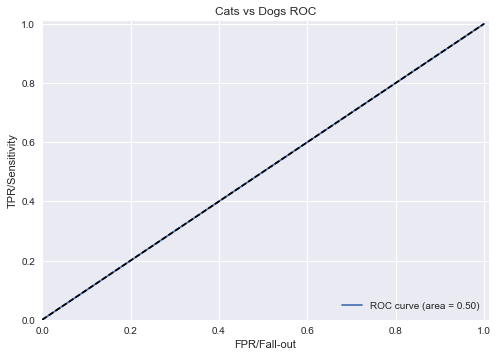

In [137]:
fpr, tpr, thresholds = metrics.roc_curve(test_y,knn_test_y)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Cats vs Dogs ROC")
plt.legend(loc = 'lower right')
plt.savefig ('test.jpg', dpi=300, transparent=False)
plt.show()

In [54]:
knn_model_y=knn.predict(train_data)
print (classification_report(train_y,knn_model_y))

             precision    recall  f1-score   support

          0       0.64      0.62      0.63     12500
          1       0.63      0.64      0.64     12500

avg / total       0.63      0.63      0.63     25000



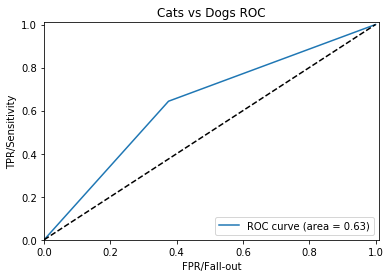

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(train_y,knn_model_y)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Cats vs Dogs ROC")
plt.legend(loc = 'lower right')
plt.show()

In [39]:
train_x=np.array(train_data)

In [40]:
train_x.shape

(25000, 256)

In [55]:
svm=SVR('linear')
svm.fit(train_data,train_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [56]:
y_predict_svm = svm.predict(train_data)
svm_accuracy = np.where(y_predict_svm == train_y, 1, 0).sum()/float(len(train_y))

In [57]:
svm_accuracy

0.51104000000000005

In [59]:
from sklearn.metrics import classification_report
print (classification_report(train_y,y_predict_svm))

             precision    recall  f1-score   support

          0       0.51      0.49      0.50     12500
          1       0.51      0.54      0.52     12500

avg / total       0.51      0.51      0.51     25000



In [87]:
from sklearn import metrics
from sklearn.metrics import classification_report
k_range=range(1,10)
precision_scores=[]
accuracy_train=[]

for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_x,y_train_)
    y_pred=knn.predict(train_x)
    
    print (classification_report(y_train_,y_pred))
    TP = conf_mat[1,1]
    TN = conf_mat[0,0]
    FP = conf_mat[0,1]
    FN = conf_mat[1,0]
    precision_scores.append(TP/float((FP + TP)))
    knn_accuracy = np.where(y_pred == y_train_, 1, 0).sum()/float(len(y_train_))
    accuracy_train.append(knn_accuracy)
list(zip(k_range, precision_scores))

             precision    recall  f1-score   support

          0       0.86      0.87      0.87     10004
          1       0.87      0.86      0.86      9996

avg / total       0.86      0.86      0.86     20000

             precision    recall  f1-score   support

          0       0.63      0.95      0.76     10004
          1       0.90      0.45      0.60      9996

avg / total       0.77      0.70      0.68     20000

             precision    recall  f1-score   support

          0       0.71      0.71      0.71     10004
          1       0.71      0.71      0.71      9996

avg / total       0.71      0.71      0.71     20000

             precision    recall  f1-score   support

          0       0.62      0.85      0.71     10004
          1       0.76      0.47      0.58      9996

avg / total       0.69      0.66      0.65     20000

             precision    recall  f1-score   support

          0       0.67      0.66      0.66     10004
          1       0.66      0.68 

[(1, 0.49939686369119424),
 (2, 0.49939686369119424),
 (3, 0.49939686369119424),
 (4, 0.49939686369119424),
 (5, 0.49939686369119424),
 (6, 0.49939686369119424),
 (7, 0.49939686369119424),
 (8, 0.49939686369119424),
 (9, 0.49939686369119424)]

In [65]:
from sklearn import metrics
from sklearn.metrics import classification_report
k_range=range(1,10)
precision_scores=[]
accuracy_test=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_x,y_train_)
    y_pred=knn.predict(test_x)
    conf_mat=metrics.confusion_matrix(test_y,y_pred)
    print (conf_mat)
    print (classification_report(test_y,y_pred))
    TP = conf_mat[1,1]
    TN = conf_mat[0,0]
    FP = conf_mat[0,1]
    FN = conf_mat[1,0]
    print ("if k ={} precision is {}".format(k,(TP/float((FP + TP)))))
    precision_scores.append(TP/float((FP + TP)))
    knn_accuracy = np.where(y_pred == test_y, 1, 0).sum()/float(len(test_y))
    accuracy_test.append(knn_accuracy)
    
list(zip(k_range, precision_scores))

[[1261 1235]
 [1265 1239]]
             precision    recall  f1-score   support

          0       0.50      0.51      0.50      2496
          1       0.50      0.49      0.50      2504

avg / total       0.50      0.50      0.50      5000

if k =1 precision is 0.500808407437
[[1889  607]
 [1886  618]]
             precision    recall  f1-score   support

          0       0.50      0.76      0.60      2496
          1       0.50      0.25      0.33      2504

avg / total       0.50      0.50      0.47      5000

if k =2 precision is 0.504489795918
[[1258 1238]
 [1243 1261]]
             precision    recall  f1-score   support

          0       0.50      0.50      0.50      2496
          1       0.50      0.50      0.50      2504

avg / total       0.50      0.50      0.50      5000

if k =3 precision is 0.504601840736
[[1746  750]
 [1736  768]]
             precision    recall  f1-score   support

          0       0.50      0.70      0.58      2496
          1       0.51      0.31

[(1, 0.50080840743734845),
 (2, 0.5044897959183674),
 (3, 0.50460184073629455),
 (4, 0.50592885375494068),
 (5, 0.50078926598263618),
 (6, 0.50837666088965916),
 (7, 0.50815758058097893),
 (8, 0.50770047796070106),
 (9, 0.49939686369119424)]

In [111]:
k=[1,3,5,7,9]
print accuracy_train
print accuracy_test


[0.86480000000000001, 0.70045000000000002, 0.70740000000000003, 0.66000000000000003, 0.66764999999999997, 0.63985000000000003, 0.64259999999999995, 0.63, 0.62909999999999999]
[0.5, 0.50139999999999996, 0.50380000000000003, 0.50280000000000002, 0.5, 0.505, 0.50739999999999996, 0.505, 0.49859999999999999]


In [113]:
train=[]
for i in range(10):
    if i%2==0:
        train.append(accuracy_train[i])
        
test=[]
for i in range(10):
    if i%2==0:
        test.append(accuracy_test[i])

In [122]:
train

[0.86480000000000001,
 0.70740000000000003,
 0.66764999999999997,
 0.64259999999999995,
 0.62909999999999999]

In [123]:
test

[0.5, 0.50380000000000003, 0.5, 0.50739999999999996, 0.49859999999999999]

In [116]:
range(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [120]:
import pandas as pd


In [124]:
al=pd.DataFrame({"train":train,"test":test})
al

,test,train
0,0.5000,0.86480
1,0.5038,0.70740
2,0.5000,0.66765
3,0.5074,0.64260
4,0.4986,0.62910


In [92]:
bc= pd.DataFrame({ "test":test,"train":train },index=[1,3,5,7,9])
bc

,test,train
1,0.86480,0.5000
3,0.70740,0.5038
5,0.66765,0.5000
7,0.64260,0.5074
9,0.62910,0.4986


In [125]:
frame2=pd.DataFrame(al,columns=["test","train"])
frame2

,test,train
0,0.5000,0.86480
1,0.5038,0.70740
2,0.5000,0.66765
3,0.5074,0.64260
4,0.4986,0.62910


In [94]:
frame2

,train,test
1,0.5000,0.86480
3,0.5038,0.70740
5,0.5000,0.66765
7,0.5074,0.64260
9,0.4986,0.62910


In [126]:
al

,test,train
0,0.5000,0.86480
1,0.5038,0.70740
2,0.5000,0.66765
3,0.5074,0.64260
4,0.4986,0.62910


In [127]:
frame2=frame2.stack()

In [129]:
frame2

0  test     0.50000
   train    0.86480
1  test     0.50380
   train    0.70740
2  test     0.50000
   train    0.66765
3  test     0.50740
   train    0.64260
4  test     0.49860
   train    0.62910
dtype: float64

In [130]:
frame2.columns = ["K-value", "type", "accuracy"]

In [131]:
import seaborn as sns

In [132]:
frame2=frame2.reset_index()

In [133]:
frame2.columns = ["K-value", "type", "accuracy"]

In [134]:
frame2

,K-value,type,accuracy
0,0,test,0.50000
1,0,train,0.86480
2,1,test,0.50380
3,1,train,0.70740
4,2,test,0.50000
5,2,train,0.66765
6,3,test,0.50740
7,3,train,0.64260
8,4,test,0.49860
9,4,train,0.62910


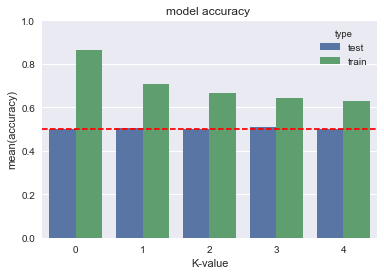

In [135]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,4))
plt.title('model accuracy ')

sns.barplot(x="K-value", y="accuracy", hue="type", data=frame2)
plt.axhline(y=0.5,c='r',ls="--")
plt.ylim(0,1)
plt.savefig ('knn_accuracy1.jpg', dpi=300, transparent=False)
plt.show()

In [154]:
svm=SVR(kernel='linear',C=0.0001)
svm.fit(train_x,y_train_)

SVR(C=0.0001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [155]:
svm_y=svm.predict(test_x)

In [163]:
svm_k=[]
for a in svm_y:
    if a>0.5:
        svm_k.append(1)
    else :
        svm_k.append(0)

In [164]:
len(svm_k)

5000

In [161]:
len(test_x)

5000

In [165]:
print (classification_report(test_y,svm_k))

             precision    recall  f1-score   support

          0       0.52      0.47      0.50      2496
          1       0.52      0.57      0.54      2504

avg / total       0.52      0.52      0.52      5000



In [153]:
from sklearn.grid_search import GridSearchCV



param_range = {'kernel':('linear','rbf'),
               'C':[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
svc=SVR()
gs = GridSearchCV(estimator=svc, param_range,n_jobs=2,cv=5,scoring="accuracy")
%time gs = gs.fit(train_x, y_train_)

SyntaxError: non-keyword arg after keyword arg (<ipython-input-153-8c067aabac95>, line 8)